In [24]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Type
from planning.map.type import Coor
from planning.map import BuildingMap, BuildingMapGenConfig
from planning.scenarios import ScenarioConfig, Scenario, ScenarioSize
from planning.map.util import manhattan_distance, euclidean_distance, clip
from planning.planner import AStarPlanner, DijkstraPlanner, DFSPlanner, RRTPlanner, RRTStarPlanner, Planner
from planning.experiment import run_planner

In [ ]:
sns.set_style("darkgrid")

# Benchmark

In [21]:
def run_seeds(n_seed: int, scenario_size: ScenarioSize):
    benchmark_results = []
    pbar = tqdm(total=n_seed * 5)
    for seed in range(n_seed):
        bmap, src, target = Scenario.get(seed, scenario_size)
        astar_planner = AStarPlanner(bmap)
        dijkstra_planner = DijkstraPlanner(bmap)
        dfs_planner = DFSPlanner(bmap)
        # RRT specific
        max_streering_radius = clip(bmap.shape[0] // 20, 2, 10)
        destination_reached_radius = clip(bmap.shape[0] // 25, 5, 8)
        neighbor_radius = clip(bmap.shape[0]//25, 5, 8)
        rrt_max_step = bmap.shape[0] * 50
        rrt_planner = RRTPlanner(bmap, max_streering_radius = max_streering_radius, max_steps = rrt_max_step, destination_reached_radius = destination_reached_radius)
        rrt_star_planner = RRTStarPlanner(bmap, max_streering_radius = max_streering_radius, max_steps = rrt_max_step, 
                                            destination_reached_radius = destination_reached_radius, neighbor_radius = neighbor_radius, quit_early = False)
        for planner in [astar_planner, dijkstra_planner, dfs_planner, rrt_planner, rrt_star_planner]:
            pbar.set_postfix({"seed": seed, "planner": planner.__class__.__name__})
            benchmark_results.append(run_planner(bmap, planner, src, target, seed))
            pbar.update()
    return pd.DataFrame(benchmark_results)


## Small Map

In [5]:
xs_df = run_seeds(5, scenario_size=ScenarioSize.XS)
s_df = run_seeds(5, scenario_size=ScenarioSize.S)
m_df = run_seeds(5, scenario_size=ScenarioSize.M)

100%|██████████| 25/25 [01:18<00:00,  3.14s/it, seed=4, planner=RRTStarPlanner]


# Time Complexity Growth

In [23]:
def time_planner(n_seed: int, sizes: List[int], planner_class: Type[Planner]):
    result = []
    pbar = tqdm(total=n_seed * len(sizes))
    for seed in range(n_seed):
        np.random.seed(n_seed)
        for size in sizes:
            pbar.set_postfix({"Seed": seed, "Size": size})
            config = BuildingMapGenConfig(width1=size, width2=size, height=size, n_building=size // 2,
                                          min_building_size=size // 4,
                                          max_building_size=size // 2, max_building_height=size,
                                          sample_point_max_height=2)
            bmap, src, target = Scenario.get_with_config(config)
            planner = planner_class(bmap)
            solved, visited, path = planner.plan(src, target)
            result.append(run_planner(bmap, planner, src, target, seed))
            pbar.update()
    return pd.DataFrame(result)

sizes = [10, 20, 40, 60, 80, 100]
astar_time_df = time_planner(5, sizes=sizes, planner_class=AStarPlanner)
dijkstra_time_df = time_planner(5, sizes=sizes, planner_class=DijkstraPlanner)
dfs_time_df = time_planner(5, sizes=sizes, planner_class=DFSPlanner)
rrt_time_df = time_planner(5, sizes=sizes, planner_class=RRTPlanner)


100%|██████████| 30/30 [00:02<00:00, 13.26it/s, Seed=4, Size=100]


Text(0, 0.5, 'Time Taken (s)')

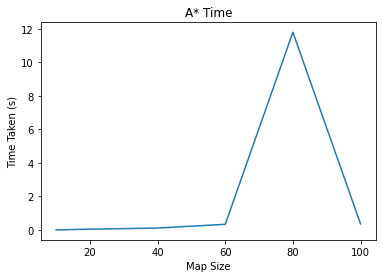

In [29]:
agg = astar_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="time_taken").set_title("A* Time")
plt.xlabel("Map Size")
plt.ylabel("Time Taken (s)")

Text(0, 0.5, 'Time Taken (s)')

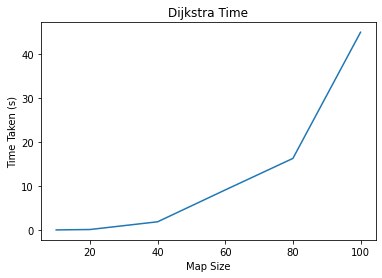

In [30]:
agg = dijkstra_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="time_taken").set_title("Dijkstra Time")
plt.xlabel("Map Size")
plt.ylabel("Time Taken (s)")

Text(0, 0.5, 'Time Taken (s)')

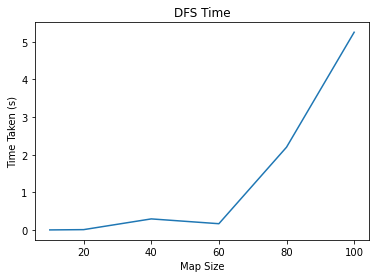

In [31]:
agg = dfs_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="time_taken").set_title("DFS Time")
plt.xlabel("Map Size")
plt.ylabel("Time Taken (s)")

Text(0, 0.5, 'Time Taken (s)')

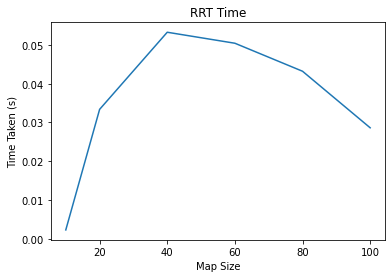

In [32]:
agg = rrt_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="time_taken").set_title("RRT Time")
plt.xlabel("Map Size")
plt.ylabel("Time Taken (s)")

In [22]:
bmap, src, target = Scenario.get(0, ScenarioSize.L)
rrt_planner = RRTStarPlanner(bmap, max_steps=5000)
solved, visited, path = rrt_planner.plan(src, target)
solved

KeyboardInterrupt: 